# <font color=green>LivingEarth PNG - FAO LCCS Level 3</font>

### An environmental layers testing framework for the FAO land cover classification system

The purpose of this notebook is to provide an easy-to-use method for testing environmental layers to use for classification and seeing how changes to particular layers effect the final Land Cover Classification. You can easily test with different environmental layer inputs, and different locations. 

This code defines 5 variables to contain the binary layers required to reach a level 3 classification:
1. <font color=blue>**vegetat_veg_cat:**</font> Vegetated / Non-Vegetated 
2. <font color=blue>**aquatic_wat_cat:**</font> Aquatic / Terrestrial 
3. <font color=blue>**cultman_agr_cat:**</font> Natural Vegetation / Crop or Managed Vegetation
4. <font color=blue>**artific_urb_cat:**</font> Natural Surfaces / Artificial Surfaces
5. <font color=blue>**artwatr_wat_cat:**</font> Natural Water / Artificial Water

Whilst this example is using open data cube to load the required data, it can be loaded from anywhere - so long as all input layers cover the same geographic region and are defined in a correctly labelled dataset, before being passed to the classification code.

#### Install the environment (need DEA fc and wofs packages) using the following on command line

In [1]:
'''
python3 -m venv ~/venvs/VP_Environment
source ~/venvs/VP_Environment/bin/activate
deactivate
realpath /env/lib/python3.10/site-packages > ~/venvs/VP_Environment/lib/python3.10/site-packages/base_venv.pth
source ~/venvs/VP_Environment/bin/activate
pip install --extra-index-url=https://packages.dea.ga.gov.au/ fc
pip install ephem
pip install --index-url https://packages.dea.ga.gov.au/ wofs
python -m ipykernel install --user --name=VP_Environment
cd venvs/VP_Environment
touch setup.py

##### add in text below to setup.py

from setuptools import setup, find_packages

setup(
    name='VP_Environment',
    version='1.0',
    packages=find_packages(),
    install_requires=[
        'ephem',
        'wofs',
        'fc'
    ],
)

#####

python setup.py bdist_egg

'''

"\npython3 -m venv ~/venvs/VP_Environment\nsource ~/venvs/VP_Environment/bin/activate\ndeactivate\nrealpath /env/lib/python3.10/site-packages > ~/venvs/VP_Environment/lib/python3.10/site-packages/base_venv.pth\nsource ~/venvs/VP_Environment/bin/activate\npip install --extra-index-url=https://packages.dea.ga.gov.au/ fc\npip install ephem\npip install --index-url https://packages.dea.ga.gov.au/ wofs\npython -m ipykernel install --user --name=VP_Environment\ncd venvs/VP_Environment\ntouch setup.py\n\n##### add in text below to setup.py\n\nfrom setuptools import setup, find_packages\n\nsetup(\n    name='VP_Environment',\n    version='1.0',\n    packages=find_packages(),\n    install_requires=[\n        'ephem',\n        'wofs',\n        'fc'\n    ],\n)\n\n#####\n\npython setup.py bdist_egg\n\n"

### **Import modules**

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os, sys

import numpy as np
import xarray as xr
import geopandas as gpd
import rasterio

from matplotlib import pyplot
import matplotlib.pyplot as plt

import datacube
from datacube.utils import masking
from datacube.utils.geometry import CRS
from dea_tools.plotting import display_map
from dea_tools.spatial import xr_rasterize

#import le_lccs modules
sys.path.append("../../livingearth_lccs")
from le_lccs.le_ingest import gridded_ingest
from le_lccs.le_classification import lccs_l3

# for virtual products
sys.path.insert(1, "/home/jovyan/code/livingearth_png/le_plugins")
import yaml
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER

# outputs
from datacube.utils.cog import write_cog
from datacube.drivers.netcdf import write_dataset_to_netcdf

dc = datacube.Datacube(app="level3")

# virtual product catalog
catalog = catalog_from_file('../le_plugins/virtual_product_cat.yaml')

#### AWS Access

In [3]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True) ### add client=client here if launching a dask cluster

#### display AOI

In [4]:
# # Western Gulf mangrove area
latitude = (-7.3, -7.4)
longitude = (144.4, 144.5)

# # Port Moresby
# latitude = (-9.4, -9.5)
# longitude = (147.1, 147.2)

display_map(longitude, latitude)

## <font color=blue>Set up query</font>

In [5]:
time = ('2020-01-01', '2020-12-31')

crs = "EPSG:32755"
res = (30, -30)

query =({'time': time,
             'latitude':latitude,
            'longitude':longitude,
            'output_crs':crs,
            'resolution':res})

## <font color=blue>Create environmental layers</font>

### 1. Vegetated / Non-Vegetated

   * **Primarily Vegetated Areas**:
   This class applies to areas that have a vegetative cover of at least 4% for at least two months of the year, consisting of Woody (Trees, Shrubs) and/or Herbaceous (Forbs, Graminoids) lifeforms, or at least 25% cover of Lichens/Mosses when other life forms are absent.
      
   * **Primarily Non-Vegetated Areas**:
   Areas which are not primarily vegetated.
 

Fractional cover (FC) is used to distinguish between vegetated and not vegetated. 
http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover
<br>We are using the 90th annual percentile for both Photosyntheic (PV) and Non-photosynthetic (NPV) vegetation. This removes noise and outliers and gives a robust maximum annual value. A threshold is then applied where PV or NPV is greater than 50%, the rationale being that if a pixel is greater than 50% PV or NPV we can be confident that it is likely to be vegetated. In addition, a maximum threshold value is given to NPV as non-photosynthetic vegetation and bare soil (BS) fractions can be unreliable at maximum values due to inherent issues with unmixing NPV and BS signatures.

<font color=red>**TODO:**</font> need to calculate number of observations for annual time series to define vegetation correctly as in FAO guidelines. This will likely be similar to WOfS wet/clear obervations but for FC where PV or NPV is greater than 50% for 60 days per year

In [6]:
# Load Fractional Cover

# Need to add any tranformations for the VP you're using
# Get location of transformation
transformation = "fractional_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [7]:
product = catalog['fractional_cover']
fractional_cover = product.load(dc, **query)
fractional_cover = masking.mask_invalid_data(fractional_cover)

In [8]:
# Load WOfS

# Need to add any tranformations for the VP you're using
# Get location of transformation
transformation = "WOfS"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [9]:
product = catalog['WOfS']
wofs = product.load(dc, **query)
wofs = masking.mask_invalid_data(wofs)

wofs_mask = wofs["frequency"] >= 0.2

In [10]:
# Create binary layer representing vegetated (1) and non-vegetated (0)
vegetat = ((fractional_cover["PV_PC_90"] >= 50) | ((fractional_cover["NPV_PC_90"] >= 50) & (fractional_cover["NPV_PC_90"] <= 80)))

# mask out water here
vegetat = vegetat.where(wofs_mask == 0, 0, 1)

# Convert to Dataset and add name
vegetat_veg_cat_ds = vegetat.to_dataset(name="vegetat_veg_cat")#.squeeze().drop('time')

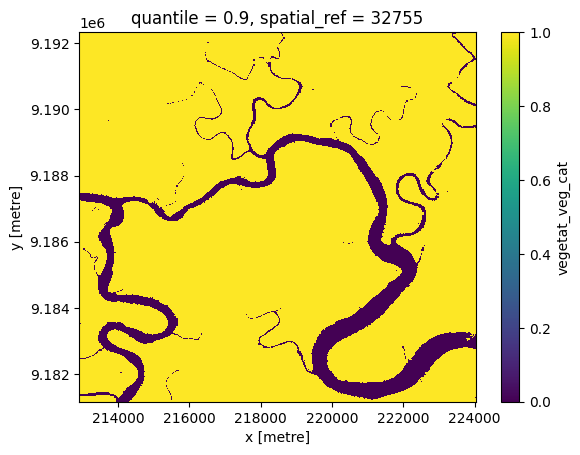

In [11]:
vegetat_veg_cat_ds.vegetat_veg_cat.plot()

### 2. Aquatic / Terrestrial

   * **Primarily Vegetated, Terrestrial**: The vegetation is influenced by the edaphic substratum
   * **Primarily Non-Vegetated, Terrestrial**: The cover is influenced by the edaphic substratum
   * **Primarily Vegetated, Aquatic or regularly flooded**: The environment is significantly influenced by the presence of water over extensive periods of time. The water is the dominant factor determining natural soil development and the type of plant communities living on its surface
   * **Primarily Non-Vegetated, Aquatic or regularly flooded**: Permanent or regularly flood aquatic areas
   

Water Observations from Space (WOfS) is used to distinguish aquatic and terrestrial areas.
https://www.sciencedirect.com/science/article/pii/S0034425715301929?via%3Dihub
<br> A threshold of 20% is applied for the annual summary dataset to remove flood events not indicative of the landscape.
<br>The Mangrove layer are also used for relevant coastal landscapes.


In [12]:
# note: wofs (loaded in level 1 as wofs_mask)

# load mangroves as mask
gmw_2020 = '../data/GMW/gmw_v3_2020_vec.shp'

# load in mangrove vector data just for AOI extent
bbox = [longitude[0], latitude[1], longitude[1], latitude[0]]

# Load the mangrove vector data within the AOI extent
gmw = gpd.read_file(gmw_2020, bbox=bbox)

# Check if the mangrove vector dataset is empty
if gmw.empty:
    # If the mangrove vector dataset is empty, create a raster of zeros matching the shape of the WOfS mask
    mangrove = xr.DataArray(np.zeros_like(wofs_mask), coords=wofs_mask.coords, dims=wofs_mask.dims, attrs=wofs_mask.attrs)
else:
    # If the mangrove vector dataset is not empty, rasterize it to match the shape of the WOfS mask
    # Get the bounding box coordinates
    xmin, ymin, xmax, ymax = bbox
    
    # Get the mangrove vector data within the AOI extent
    gmw_aoi = gmw.cx[xmin:xmax, ymin:ymax]
    
    # Rasterize the mangrove vector data to match the shape of the WOfS mask
    mangrove = xr_rasterize(gdf=gmw_aoi, da=wofs_mask)


In [13]:
# Create binary layer representing aquatic (1) and terrestrial (0)

# For coastal landscapes use the following
aquatic_wat = (wofs_mask | mangrove)

# Convert to Dataset and add name
aquatic_wat_cat_ds = aquatic_wat.to_dataset(name="aquatic_wat_cat")#.squeeze().drop('time')             

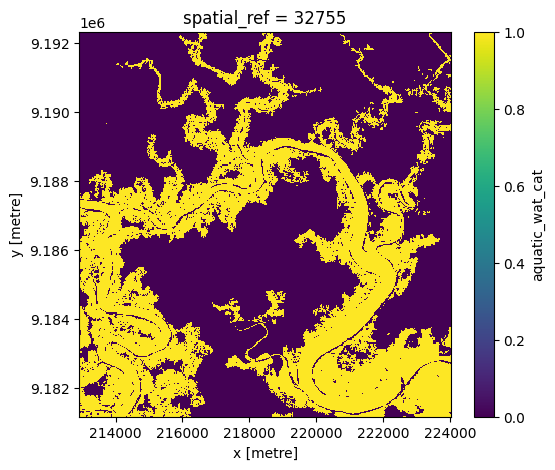

In [14]:
# Plot output
aquatic_wat_cat_ds["aquatic_wat_cat"].plot.imshow(figsize=(6, 5))

### 3. Natural Vegetation / Crop or Managed Vegetation

   * **Primarily Vegetated, Terrestrial, Artificial/Managed**: Cultivated and Managed Terrestrial Areas
   * **Primarily Vegetated, Terrestrial, (Semi-)natural**: Natural and Semi-Natural Vegetation
   * **Primarily Vegetated, Aquatic or Regularly Flooded, Artificial/Managed**: Cultivated Aquatic or Regularly Flooded Areas
   * **Primarily Vegetated, Aquatic or Regularly Flooded, (Semi-)natural**: Natural and Semi-Natural Aquatic or Regularly Flooded Vegetation

<font color=red>**TODO:** Carole and Annette exploring sentinel-1 options here </font>

In [15]:
# Need to add any tranformations for the VP you're using
# Get location of transformation
transformation = "geomedian"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [16]:
# load geomedian
product = catalog['geomedian']
geomedian = product.load(dc, **query)

In [17]:
# Create binary layer representing cultivated (1) and natural (0)

# calculate NDVI (PLACEHOLDER)
NDVI = (geomedian.nbart_nir-geomedian.nbart_red)/(geomedian.nbart_nir+geomedian.nbart_red)
cultman = (NDVI >= 0.4) & (NDVI <= 0.7)

# Convert to Dataset and add name
cultman_agr_cat_ds = cultman.to_dataset(name="cultman_agr_cat")#.squeeze().drop('time')

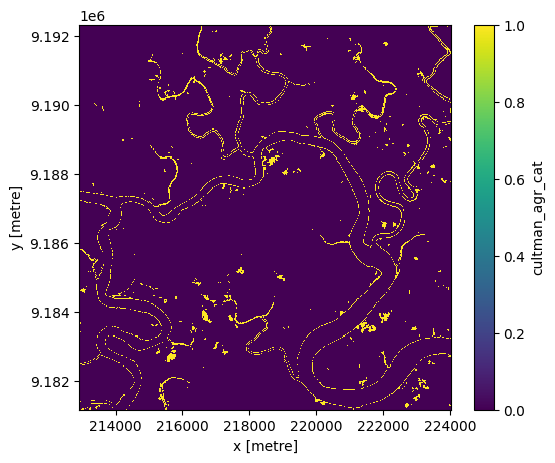

In [18]:
# Plot output
cultman_agr_cat_ds["cultman_agr_cat"].plot.imshow(figsize=(6, 5))

### 4. Natural Surfaces / Artificial Surfaces

NONE

### 5. Natural Water / Artificial Water

NONE

### **Collect environmental variables into array for passing to classification system**

In [19]:
variables_xarray_list = []
variables_xarray_list.append(vegetat_veg_cat_ds)
variables_xarray_list.append(aquatic_wat_cat_ds)
variables_xarray_list.append(cultman_agr_cat_ds)
# variables_xarray_list.append(artific_urb_cat_ds)
# variables_xarray_list.append(artwatr_wat_cat_ds)

## <font color=blue>Classification</font>

**The LCCS classificaition is hierachial. The 8 classes are shown below**

| Class name | Code | Numeric code |
|----------------------------------|-----|-----|
| Cultivated Terrestrial Vegetated | A11 | 111 |
| Natural Terrestrial Vegetated | A12 | 112 |
| Cultivated Aquatic Vegetated | A23 | 123 |
| Natural Aquatic Vegetated | A24 | 124 |
| Artificial Surface | B15 | 215 |
| Natural Surface | B16 | 216 |
| Artificial Water | B27 | 227 |
| Natural Water | B28 | 228 |


In [20]:
# Merge to a single dataframe
classification_data = xr.merge(variables_xarray_list)

In [21]:
# Apply Level 3 classification using separate function. Works through in three stages
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

In [22]:
# Save classification values back to xarray
out_class_xarray = xr.Dataset(
    {"level1" : (classification_data["vegetat_veg_cat"].dims, level1),
     "level2" : (classification_data["vegetat_veg_cat"].dims, level2),
     "level3" : (classification_data["vegetat_veg_cat"].dims, level3)})
classification_data = xr.merge([classification_data, out_class_xarray])

## <font color=blue>Results</font>

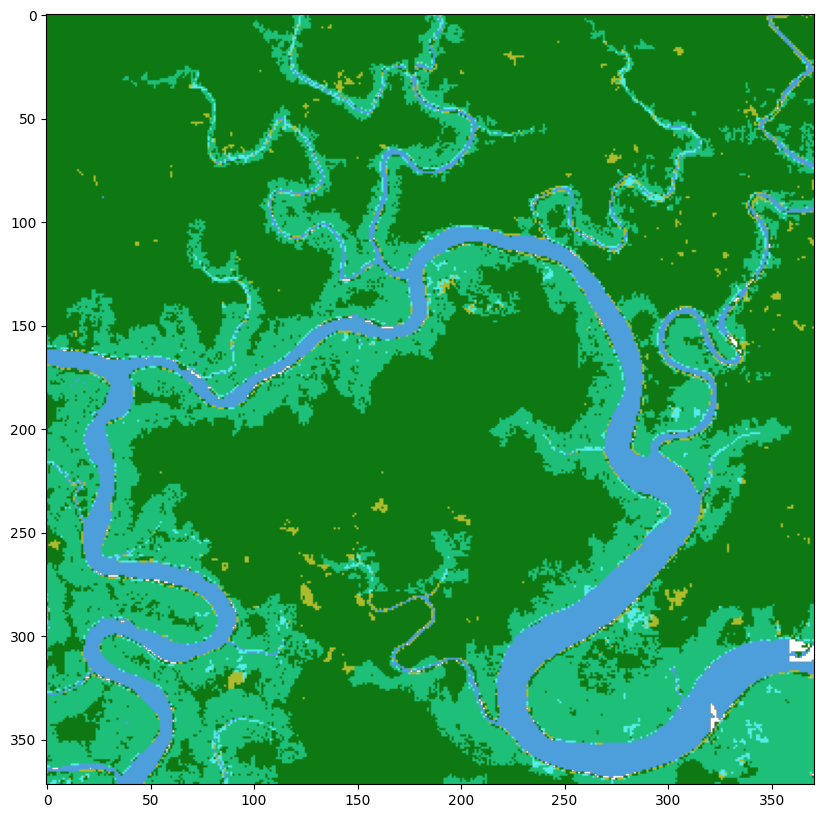

In [23]:
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3)
img = np.dstack([red, green, blue, alpha])

# Rotate the image by 180 degrees - SHOULDN'T HAVE TO DO THIS BUT WAS NOT DISPLAYING PROPERLY
img = np.rot90(img, 2)

# Display the rotated image
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.show()


### **Save results to geotiff**

In [24]:
# min_x = classification_data.coords['x'].min().values
# max_x = classification_data.coords['x'].max().values
# min_y = classification_data.coords['y'].min().values
# max_y = classification_data.coords['y'].max().values

# res_x = 30 
# res_y = -30 
# crs = 'EPSG:32755'
# # Write out
# output_rgb_file_name = "../data/level3_test.tif"
# out_file_transform = [res_x, 0, min_x, 0, res_y, max_y]
# output_x_size = int((max_x - min_x)/res_x)
# output_y_size = int((min_y - max_y)/res_y)

# # Write RGB colour scheme out
# rgb_dataset = rasterio.open(output_rgb_file_name, 'w', driver='GTiff',
#                             height=output_y_size, width=output_x_size,
#                             count=3, dtype=level3.dtype,
#                             crs=crs, transform=out_file_transform)
# rgb_dataset.write(red, 1)
# rgb_dataset.write(green, 2)
# rgb_dataset.write(blue, 3)
# rgb_dataset.close()